In [41]:
load("grant_Data.Rdata")

`there are 1073 predictors in fullSet, However the book show only 1070 predictors @page 311`

In [42]:
#remove zear var cols first before scaling
ZeroVarCol <- c("Sponsor260D","Sponsor281A" , "Sponsor315C")
fullSet <- fullSet[! fullSet %in% ZeroVarCol]

In [5]:
reducedCovMat <- cov(training[,reducedSet])
library(subselect)
trimmingResults <- trim.matrix(reducedCovMat)
names(trimmingResults)
trimmingResults$names.discarded

[1] "trimmedmat"        "numbers.discarded" "names.discarded"  
[4] "size"

character(0)

In [6]:
#apply to full set
fullCovMat <- cov(training[,fullSet])
fullSetResults <- trim.matrix(fullCovMat)
fullSetResults$names.discarded

[1] "NumDR"       "NumPS"       "PS.Dept1033" "CI.Dept118"  "PS.Dept3258"
[6] "CTotal"      "numPeople"   "Jun"         "Wed"

In [7]:
levels(training$Class)

[1] "successful"   "unsuccessful"

In [8]:
library(caret)
fit_glt <- glm(Class~Day,
              data=training[pre2008,],
              family=binomial)
fit_glt

Loading required package: lattice
Loading required package: ggplot2



Call:  glm(formula = Class ~ Day, family = binomial, data = training[pre2008, 
    ])

Coefficients:
(Intercept)          Day  
  -0.919335     0.004238  

Degrees of Freedom: 6632 Total (i.e. Null);  6631 Residual
Null Deviance:	    9191 
Residual Deviance: 8919 	AIC: 8923

In [9]:
successProb <- 1- predict(
                          fit_glt,
                          newdata = data.frame(Day=c(10,150,300,350)),
                         type="response")

successProb

1         2         3         4 
0.7061907 0.5704337 0.4128749 0.3626229

In [10]:
fit_daySquared <- glm(
                      Class~Day + I(Day^2),
                     data=training[pre2008,],
                     family=binomial)
fit_daySquared


Call:  glm(formula = Class ~ Day + I(Day^2), family = binomial, data = training[pre2008, 
    ])

Coefficients:
(Intercept)          Day     I(Day^2)  
  -1.881341     0.018622    -0.000038  

Degrees of Freedom: 6632 Total (i.e. Null);  6630 Residual
Null Deviance:	    9191 
Residual Deviance: 8721 	AIC: 8727

In [11]:
library(rms)
fit_rcs <- lrm(Class~rcs(Day),data=training[pre2008,])
fit_rcs

Loading required package: Hmisc
Loading required package: survival

Attaching package: 'survival'

The following object is masked from 'package:caret':

    cluster

Loading required package: Formula

Attaching package: 'Hmisc'

The following objects are masked from 'package:base':

    format.pval, units

Loading required package: SparseM

Attaching package: 'SparseM'

The following object is masked from 'package:base':

    backsolve



Logistic Regression Model
 
 lrm(formula = Class ~ rcs(Day), data = training[pre2008, ])
 
                       Model Likelihood     Discrimination    Rank Discrim.    
                          Ratio Test           Indexes           Indexes       
 Obs          6633    LR chi2     461.53    R2       0.090    C       0.614    
  successful  3233    d.f.             4    g        0.538    Dxy     0.228    
  unsuccessful3400    Pr(> chi2) <0.0001    gr       1.713    gamma   0.237    
 max |deriv| 2e-06                          gp       0.122    tau-a   0.114    
                                            Brier    0.234                     
 
           Coef    S.E.   Wald Z Pr(>|Z|)
 Intercept -1.6833 0.1110 -15.16 <0.0001 
 Day        0.0124 0.0013   9.24 <0.0001 
 Day'      -0.0072 0.0023  -3.17 0.0015  
 Day''      0.0193 0.0367   0.52 0.6001  
 Day'''    -0.0888 0.1026  -0.87 0.3866  
 

In [12]:
max(training[pre2008,'Day'])

[1] 357

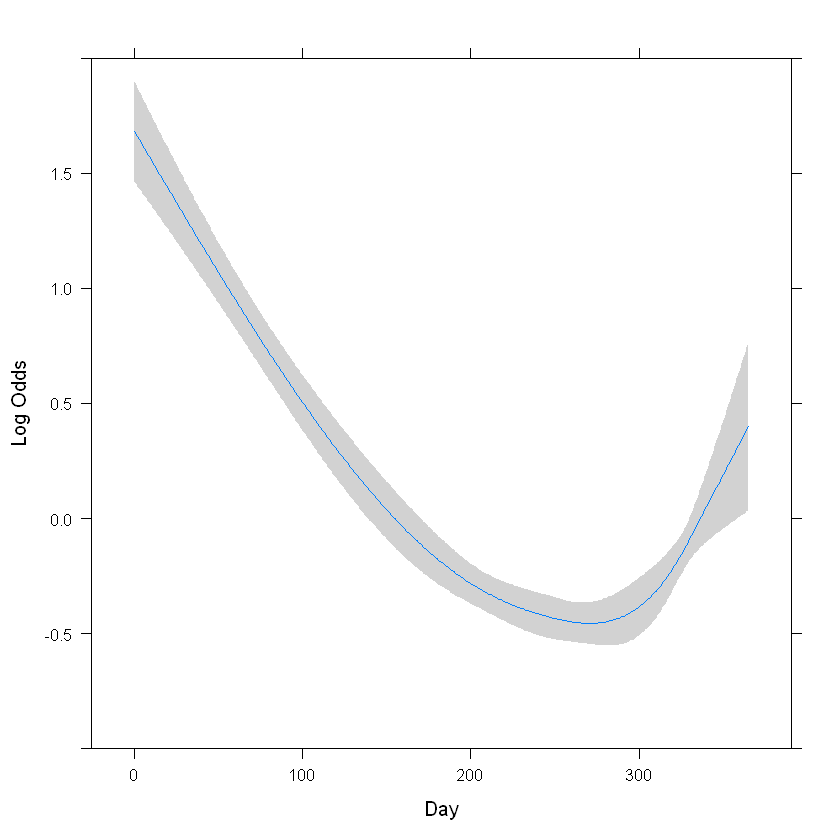

In [13]:
dayProfile <- Predict(fit_rcs,Day=0:365,fun=function(x)-x)
plot(dayProfile,ylab="Log Odds")

In [14]:
training$Day2 <- training$Day^2
fullSet <- c(fullSet,"Day2")
reducedSet <- c(reducedSet,"Day2")

In [15]:
library(caret)
set.seed(476)
ctrl <- trainControl(method = "LGOCV",
                     summaryFunction = twoClassSummary,
                     classProbs = TRUE,
                     index = list(TrainSet = pre2008),
                     savePredictions = TRUE)

fit_lrFull <- train(
                    training[,fullSet],y=training$Class,
                    method="glm",metric="ROC",trControl=ctrl)
fit_lrFull     

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Generalized Linear Model 

8190 samples
1071 predictors
   2 classes: 'successful', 'unsuccessful' 

No pre-processing
Resampling: Repeated Train/Test Splits Estimated (1 reps, 75%) 
Summary of sample sizes: 6633 
Resampling results:

  ROC        Sens       Spec     
  0.7820882  0.7701754  0.7619048


&#x1F640;
- [prediction from a rank-deficient fit may be misleading](http://bbs.pinggu.org/thread-3033898-1-1.html)
- [glm.fit: fitted probabilities numerically 0 or 1 occurred](https://blog.csdn.net/m0_37119401/article/details/71007117?locationNum=7&fps=1)

In [16]:
set.seed(476)
fit_lrReduced <- train(
                      training[,reducedSet],
                      y=training$Class,
                      method = "glm",
                      metric="ROC",
                      trControl=ctrl)
fit_lrReduced

Generalized Linear Model 

8190 samples
 253 predictor
   2 classes: 'successful', 'unsuccessful' 

No pre-processing
Resampling: Repeated Train/Test Splits Estimated (1 reps, 75%) 
Summary of sample sizes: 6633 
Resampling results:

  ROC        Sens       Spec     
  0.8715406  0.8035088  0.8216819


In [17]:
head(fit_lrReduced$pred)

pred,obs,successful,unsuccessful,rowIndex,parameter,Resample
successful,successful,0.9987762,0.001223821,6634,none,TrainSet
successful,successful,0.8515076,0.148492399,6635,none,TrainSet
successful,successful,0.9201932,0.079806850,6636,none,TrainSet
successful,successful,0.9669428,0.033057191,6637,none,TrainSet
successful,unsuccessful,0.6072577,0.392742264,6638,none,TrainSet
successful,successful,0.9892840,0.010715961,6639,none,TrainSet


In [18]:
confusionMatrix(data=fit_lrReduced$pred$pred,reference = fit_lrReduced$pred$obs)

Confusion Matrix and Statistics

              Reference
Prediction     successful unsuccessful
  successful          458          176
  unsuccessful        112          811
                                         
               Accuracy : 0.815          
                 95% CI : (0.7948, 0.834)
    No Information Rate : 0.6339         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.6107         
 Mcnemar's Test P-Value : 0.0002054      
                                         
            Sensitivity : 0.8035         
            Specificity : 0.8217         
         Pos Pred Value : 0.7224         
         Neg Pred Value : 0.8787         
             Prevalence : 0.3661         
         Detection Rate : 0.2942         
   Detection Prevalence : 0.4072         
      Balanced Accuracy : 0.8126         
                                         
       'Positive' Class : successful     
                            

Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following objects are masked from 'package:stats':

    cov, smooth, var



Area under the curve: 0.8715

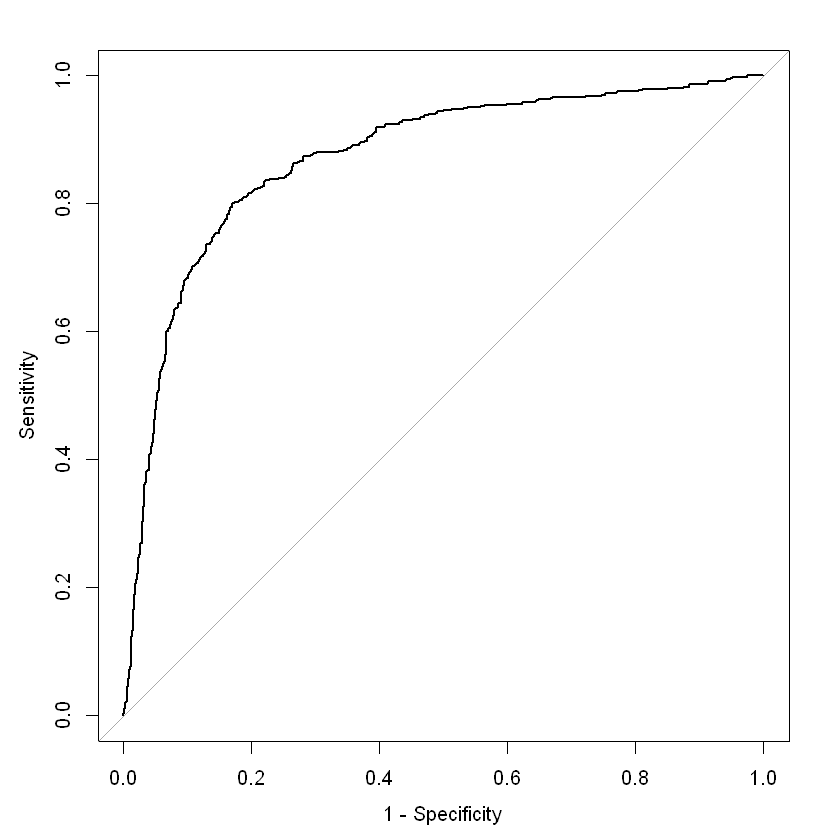

In [19]:
library(pROC)
roc_reduced <- roc(
                   response = fit_lrReduced$pred$obs,
                   predictor = fit_lrReduced$pred$successful,
                  levels=rev(levels(fit_lrReduced$pred$obs)))

plot(roc_reduced,legacy.axes=T)
auc(roc_reduced)

`Section 12.2 Logistic Regression`

In [46]:
library(caret)
fit_lgt <- glm(Class~Day,data=training[pre2008,],family=binomial)

dataGrid <- data.frame(Day=seq(0,365,length=500))
dataGrid$Linear <- 1-predict(fit_lgt,dataGrid,type="response")

linear2008 <- auc(roc(response = training[-pre2008,"Class"],
                     predictor = 1 - predict(fit_lgt,training[-pre2008,],type="response"),
                     levels=rev(levels(training[-pre2008,"Class"]))))

In [49]:
fit_lgt_sqr <- glm(Class~Day+I(Day^2),data=training[pre2008,],family=binomial)
dataGrid$Quadratic <- 1- predict(fit_lgt_sqr,dataGrid,type="response")

quadratic2008 <- auc(roc(response=training[-pre2008,"Class"],
                        predictor = 1-predict(fit_lgt_sqr,training[-pre2008,],type="response"),
                        levels = rev(levels(training[-pre2008,"Class"]))))

In [51]:
library(reshape2)
dataGrid <- melt(dataGrid,id.vars="Day")

byDay <- training[pre2008,c("Day","Class")]
byDay$Binned <- cut(byDay$Day,seq(0,360,by=5))

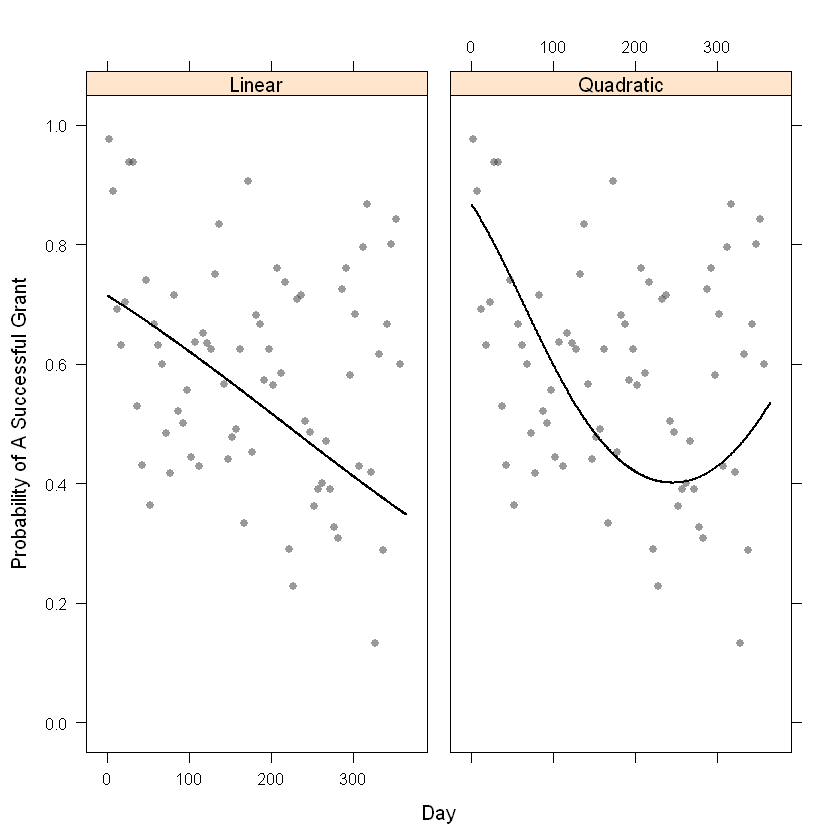

In [55]:
library(plyr)
library(lattice)
observedProps <- ddply(byDay, .(Binned),
                       function(x) c(n = nrow(x), mean = mean(x$Class == "successful")))
observedProps$midpoint <- seq(2.5, 357.5, by = 5)

xyplot(value ~ Day|variable, data = dataGrid,
       ylab = "Probability of A Successful Grant",
       ylim = extendrange(0:1),
       between = list(x = 1),
       panel = function(...)
       {
         panel.xyplot(x = observedProps$midpoint, observedProps$mean,
                      pch = 16., col = rgb(.2, .2, .2, .5))
         panel.xyplot(..., type = "l", col = "black", lwd = 2)
       })

`Linear Discriminant Analysis`

> When the number of predictors is large, the prediction equation requires a very large number of parameters to be estimated. 
For P = 2 and two classes, this equation uses four means and three variance parameters. 
In general, the model (LDA) would require CP + P*(P + 1)/2 parameters with P redictors and C classes. 
In comparison to logistic regression, a similar model would only estimate three parameters. This difference between the models becomes more significant as the number of predictors grow. 
However, the value of the extra parameters in LDA models is that the between-predictor correlations are explicitly handled by the model. This should provide some advantage to LDA over logistic regression when there are substantial correlations, although both models will break down when the multicollinearity becomes extreme.

`Pros`
- Deal substantial correlations substantial correlations


`Cons`
- Deal substantial correlations substantial correlations
- Both models break down when multicollinearity becomes extreme

In [21]:
library(MASS)
fit_scale <- preProcess(training[pre2008,reducedSet])
trn <- predict(fit_scale,newdata = training[pre2008,reducedSet])

vld <- predict(fit_scale,newdata = training[-pre2008,reducedSet])

fit_lda <- lda(x=trn,grouping=training$Class[pre2008])

In [22]:
head(fit_lda$scaling)

,LD1
NumCI,0.130167258
NumDR,0.001727461
NumECI,0.121947837
NumPS,0.004266855
NumSCI,-0.065566316
NumSR,-0.064220945


In [23]:
pred_lda <- predict(fit_lda,vld)

In [26]:
set.seed(476)
ctrl <- trainControl(method = "LGOCV",
                     summaryFunction = twoClassSummary,
                     classProbs = TRUE,
                     index = list(TrainSet = pre2008),
                     savePredictions = TRUE)

fit_lda_caret <- train(
                      x=training[,reducedSet],
                      y=training$Class,
                      method="lda",
                      preProc=c("center","scale"),
                      metric="ROC",
                      trControl=ctrl)

fit_lda_caret

Linear Discriminant Analysis 

8190 samples
 253 predictor
   2 classes: 'successful', 'unsuccessful' 

Pre-processing: centered (253), scaled (253) 
Resampling: Repeated Train/Test Splits Estimated (1 reps, 75%) 
Summary of sample sizes: 6633 
Resampling results:

  ROC        Sens       Spec    
  0.8891644  0.8035088  0.822695


In [38]:
testing$Day2 <- testing$Day^2

pred_cls <- predict(fit_lda_caret,newdata = testing[,reducedSet])

pred_prob <- predict(fit_lda_caret,newdata = testing[,reducedSet],type="prob")